In [32]:
# check available gpus
# !nvidia-smi

In [33]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [34]:
from external.loss_utils import PerceptualTextureLoss, tv_loss 
from modules.basic_utils import read_image, lazy_plot


# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image,get_texture_map



In [35]:

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [36]:
data = Renderer.load_data(  verts_T_paths,
                            tm_paths = tm_paths,
                            euler_list = euler_list)

image_resolution = 256 #128#256 # 512

In [37]:
renderer = Renderer(image_resolution=image_resolution, device=device)
renderer.load_input_params(**data)
images = renderer.render()

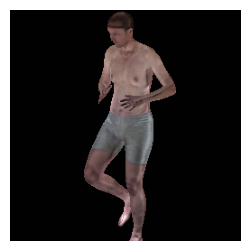

In [38]:
renderer.show()

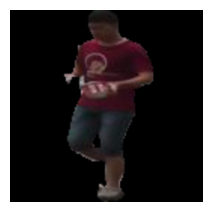

(1, 256, 256, 3)


In [39]:
tgt = remove_background(image_path,seg_mask_path)
# lazy_plot(tgt)
tgt = squared_image(tgt)
# print(tgt.shape)
# lazy_plot(tgt)
from skimage.transform import resize 
tgt = resize(tgt,[image_resolution,image_resolution,3])[None,...] # ndarray 
lazy_plot(tgt)
print(tgt.shape)

In [40]:

texture_loss = PerceptualTextureLoss()

# create texture flow 
texture_flow = torch.rand(1, 1024, 1024, 2)*2 -1
texture_flow.requires_grad = True
# texture_flow = torch.nn.Parameter(texture_flow)


tgt_pre = torch.Tensor(tgt).permute(0,3,1,2) # [1,3,256,256]
tgt_post = tgt * 255.0
# tgt_post.requires_grad = True
tgt.shape


Setting up Perceptual loss..
Done


(1, 256, 256, 3)

In [41]:
tgt_pre.shape

torch.Size([1, 3, 256, 256])

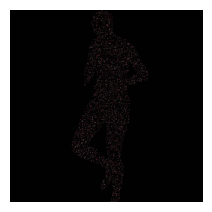

i : 0 loss: 3.1748218536376953


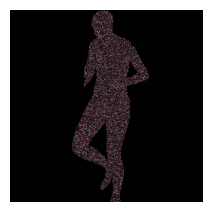

i : 200 loss: 1.8514684438705444


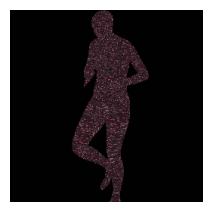

i : 400 loss: 1.7174593210220337


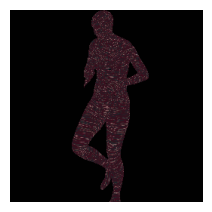

i : 600 loss: 1.6285419464111328


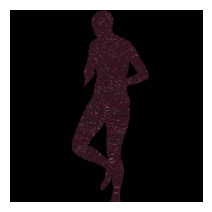

i : 800 loss: 1.551527976989746


In [42]:
# training loop to learn texture and T from image
params = [ texture_flow]
optim = torch.optim.Adam(params,lr=0.005)


for i in range(1000):
    optim.zero_grad()


    # update texture map
    renderer.texture_map = torch.nn.Parameter(get_texture_map(texture_flow,tgt_post) )
    images = renderer.render()

    images = images.permute(0,3,1,2)[:,:3,:,:].float().to(device)
    perceptual_loss = texture_loss(images,tgt_pre.float().to(device))
    tv_loss_value = tv_loss(texture_flow)
    loss = perceptual_loss  + 1 * tv_loss_value

    # just use sme
    # loss2 = images - tgt_pre.float().to(device)
    # loss2 = torch.sum(loss**2)

    # loss = loss2 #+loss
    # print('i :' , i,'loss:',loss.item())
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%200 == 0:
        lazy_plot(images)
        print('i :' , i,'loss:',loss.item())
    


In [43]:
# save texture
# plt.imsave("data/exp/tm_percep_tv.jpg",renderer.texture_map.cpu().detach().numpy().clip(0,1))

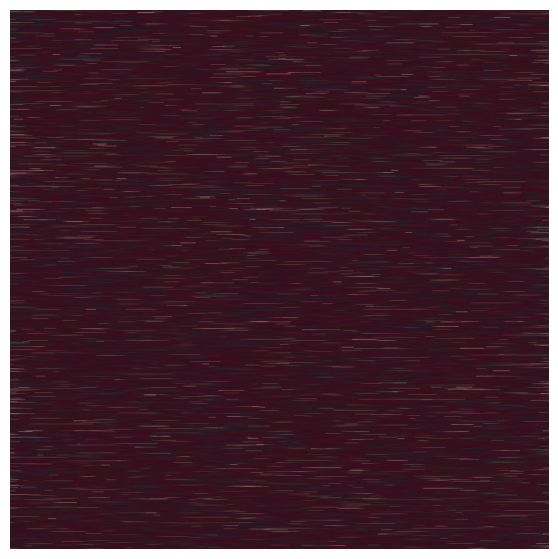

In [44]:
# renderer.texture_map
lazy_plot(renderer.texture_map,figsize=(7,7))

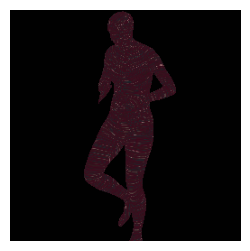

In [48]:
renderer.show()

In [46]:
get_texture_map(texture_flow,tgt_post).max()


tensor(166.4664, grad_fn=<MaxBackward1>)

In [47]:
# remove cuda cache 
torch.cuda.empty_cache()